In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize


Using TensorFlow backend.


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Exploring the data

In [5]:
df = pd.read_csv("/home/ubuntu/Desktop/Internship/Precily/all_category_data_merged.csv")
df.head(10)

,text,category
0,"CALM MELODIES AND BEAUTIFUL PICTURES Debussy, ...",art
1,Skip the art museum and come experience “Great...,art
2,Buy “Art: Music & Painting - Van Gogh on on Ca...,art
3,"Thank you for listening, I hope you will have ...",art
4,NaN,art
5,When watching this special episode of The Perf...,art
6,Sanjeev Abhyankar and Rakesh Chaurasia rendere...,art
7,"Michelangelo with Mozart, Renoir with Chopin, ...",art
8,Visit: http://www.uctv.tv/) Join the Director ...,art
9,"Wishing you better sleep, peaceful meditations...",art


# Dealing with nan values

In [6]:
df['text']=df['text'].fillna("")

In [7]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

290586

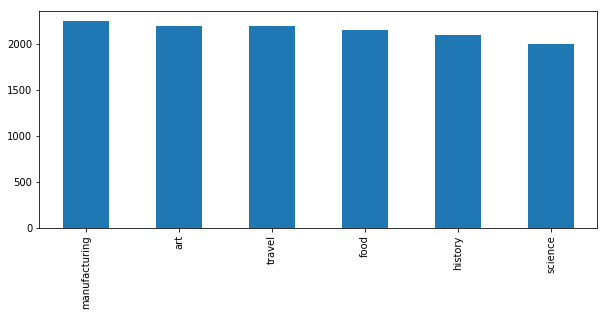

In [8]:
my_tags = ['food','manufacturing','science','travel','art','history']
plt.figure(figsize=(10,4))
df.category.value_counts().plot(kind='bar');

# Preprocessing Data

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [10]:
df['text'] = df['text'].apply(clean_text)

In [11]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))



Found 2762 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (12900, 250)


In [13]:
Y = pd.get_dummies(df['category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (12900, 6)


# Spliting Data

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11610, 250) (11610, 6)
(1290, 250) (1290, 6)


# LSTM Modelling

In [17]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
epochs = 3
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 10449 samples, validate on 1161 samples
Epoch 1/3
10449/10449 [==============================] - 62s 6ms/step - loss: 0.2698 - acc: 0.9499 - val_loss: 0.0871 - val_acc: 0.9716
Epoch 2/3
10449/10449 [==============================] - 64s 6ms/step - loss: 0.0592 - acc: 0.9798 - val_loss: 0.0660 - val_acc: 0.9724
Epoch 3/3
10449/10449 [==============================] - 65s 6ms/step - loss: 0.0507 - acc: 0.9805 - val_loss: 0.0630 - val_acc: 0.9724


In [22]:
y_pred = model.evaluate(X_test,Y_test)

1290/1290 [==============================] - 2s 2ms/step


In [31]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1290/1290 [==============================] - 2s 2ms/step
Test set
  Loss: 0.055
  Accuracy: 0.980
